In [1]:
### Load PPS model
%run ./PPS_model.ipynb

In [2]:
### Load experimental data (Di Cosmo et al., 2017)

HCdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='HC') 
SCZdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='SCZ') 
SPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='high spq') 
LSPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='low spq') 

sets = [HCdata,SCZdata,SPQdata,LSPQdata]
RTdata = []

for i in sets:
    subjects = i['Subject'].unique()
    delays = i[(i['Sound']=='Loom')&(i['Cond'] != 'Loom_NO')]['Cond'].unique()
    delays = np.delete(delays,np.where(delays=='Loom_-700')[0])
    idx = [3,4,0,1,2]
    delays = delays[idx]
    RTs = []
    
    for s in subjects:
        meanRTs = []
        for t in delays:
            RT = i[(i['Subject'] == s)&(i['Cond'] == t)]['Rtpul']           
            meanRTs.append(np.mean(RT))
        RTs.append(meanRTs)
    RTdata.append(RTs)
    
HC_RTs = np.asarray(RTdata[0])
SCZ_RTs = np.asarray(RTdata[1])
SPQ_RTs = np.asarray(RTdata[2])
LSPQ_RTs = np.asarray(RTdata[3])

In [3]:
### Audio-tactile experiment simulation setup 

## Calculate distance in cms. Speaker is positioned at 100cm from the hand. 
times = np.asarray([300,800,1500,2200,2700])
timesweep = np.arange(300,2800,100)
ts = timesweep/1000
v = 30 #cm/s 
a_distances = (120 - ts*v) # distance points in cm (network coordinates)

## Simulation setup
simtime = 100 #ms 

## Synapses setup
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5)

In [4]:
## Lateral inputs

# Tactile area
def myLIt(z,Lt): # z is a matrix of MtxNt dimensions
    LI = np.zeros(Mt*Nt)
    z = np.reshape(z,(1,Mt*Nt))
    for i in range(Mt*Nt):
            LI[i] = np.sum(np.multiply(Lt[i,:],z[0,:])) 
    LI = np.reshape(LI,(Mt,Nt))
    return LI
# Auditory area
def myLIa(z,La): # z is a matrix of MaxNa dimensions
    LI = np.zeros(Ma*Na)
    z = np.reshape(z,(1,Ma*Na))
    for i in range(Ma*Na):
            LI[i] = np.sum(np.multiply(La[i,:],z[0,:])) 
    LI = np.reshape(LI,(Ma,Na))
    return LI


## Experiment function
def myexperimentrun(a_distances,time,b,pr,Lex,Lin,Sex,Sin):
    Lt,La = Lw(Lex,Lin,Sex,Sin,Lex,Lin,Sex*20,Sin*20)
    
    dt = 0.4
    timesteps = int(time/dt)
    ndist = len(a_distances)
    
    RTs = np.zeros(ndist)
    ZTs = np.zeros((Mt,Nt,ndist))
    ZAs = np.zeros((Ma,Na,ndist))
    
    ti = PHIt(0) 
    PrBa = prun(Ba,pr)
    PrWa = prun(Wa,pr*2.6)
    dtau = dt/tau
    
    qt = np.zeros((Mt,Nt,timesteps+1,ndist))
    ut = np.zeros((Mt,Nt,timesteps+1,ndist))
    zt = np.zeros((Mt,Nt,timesteps+1,ndist))
    pt = np.zeros((Mt,Nt,timesteps+1,ndist))

    qa = np.zeros((Ma,Na,timesteps+1,ndist))
    ua = np.zeros((Ma,Na,timesteps+1,ndist))
    za = np.zeros((Ma,Na,timesteps+1,ndist))
    pa = np.zeros((Ma,Na,timesteps+1,ndist))

    qm = np.zeros((timesteps+1,ndist))
    um = np.zeros((timesteps+1,ndist))
    zm = np.zeros((timesteps+1,ndist))
    pm = np.zeros((timesteps+1,ndist))
    
    ZT = np.zeros((1,timesteps+1,ndist))
    
    for d in range(ndist):
        xa_0 = a_distances[d] # How far the sound is presented.     
        ai = PHIa(0,xa_0) # Generates an auditory input

        for i in range(timesteps):    
            # Tactile activity
            ut[:,:,i+1,d] = ti+myLIt(zt[:,:,i,d],Lt)+bt(zm[i,d])
            qt[:,:,i+1,d] = qt[:,:,i,d] + dtau*(-qt[:,:,i,d]+ut[:,:,i,d])
            pt[:,:,i+1,d] = psit(qt[:,:,i,d],b)
            zt[:,:,i+1,d] = pt[:,:,i,d]*np.heaviside(pt[:,:,i,d],0)

            ZT[0,i+1,d] = np.sum(zt[:,:,i,d])

            # Auditory activity
            ua[:,:,i+1,d] = ai+myLIa(za[:,:,i,d],La)+ba(zm[i,d],PrBa) 
            qa[:,:,i+1,d] = qa[:,:,i,d] + dtau*(-qa[:,:,i,d]+ua[:,:,i,d])
            pa[:,:,i+1,d] = psia(qa[:,:,i,d],b)
            za[:,:,i+1,d] = pa[:,:,i,d]*np.heaviside(pa[:,:,i,d],0)

            # Multisensory activity
            um[i+1,d] = np.sum(np.multiply(Wt,zt[:,:,i,d])) + np.sum(np.multiply(PrWa,za[:,:,i,d]))
            qm[i+1,d] = qm[i,d] + dtau*(-qm[i,d]+um[i,d])
            pm[i+1,d] = psim(qm[i,d])
            zm[i+1,d] = pm[i,d]*np.heaviside(pm[i,d],0)    
        RT = dt*(np.abs(ZT[:,:,d] - ZT[0,timesteps,d]*0.9)).argmin()
    
        RTs[d] = RT
        ZMs = zm        
        ZTs[:,:,d] = zt[:,:,timesteps,d]
        ZAs[:,:,d] = za[:,:,timesteps,d]   
    return RTs,ZMs,ZTs,ZAs

In [5]:
lex = 0.15
lin = 0.05
sex = 1
sin = 4

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
RTs,ZMs,ZTs,ZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

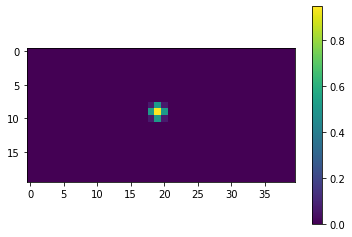

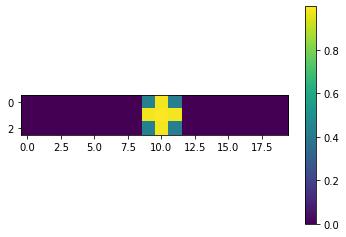

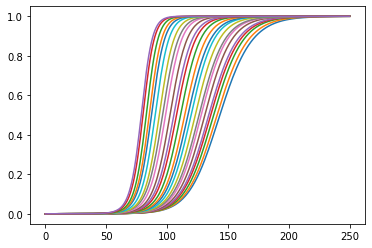

In [6]:
evdis = 2

plt.figure(2)
plt.imshow(ZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(ZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(ZMs);

In [7]:
lex = 0.15
lin = 0.90
sex = 1
sin = 0.10

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
nsRTs,nsZMs,nsZTs,nsZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

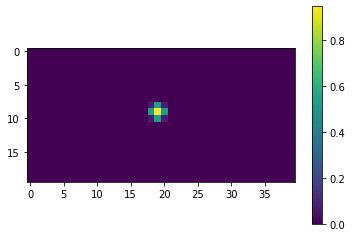

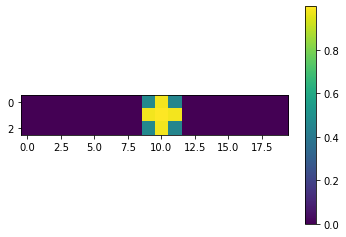

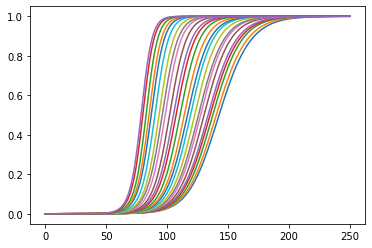

In [8]:
evdis = 2

plt.figure(2)
plt.imshow(nsZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(nsZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(nsZMs);

In [9]:
lex = 0.15
lin = 0.04
sex = 1
sin = 8.15

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
wwRTs,wwZMs,wwZTs,wwZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

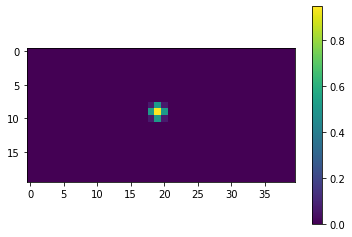

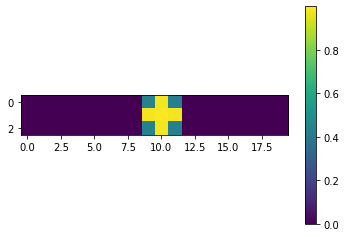

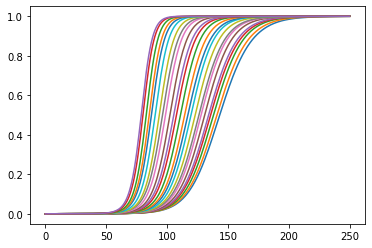

In [10]:
evdis = 2

plt.figure(2)
plt.imshow(wwZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(wwZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(wwZMs);

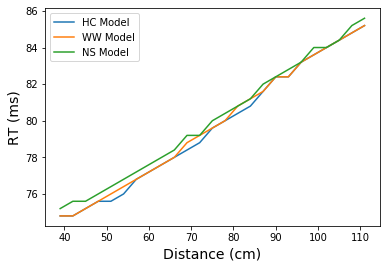

In [11]:
plt.figure(1)
plt.plot(a_distances,RTs,label = 'HC Model')
plt.plot(a_distances,wwRTs,label = 'WW Model')
plt.plot(a_distances,nsRTs,label = 'NS Model')
plt.ylabel('RT (ms)',size=14)
plt.xlabel('Distance (cm)',size=14)
plt.legend()

In [12]:
etamin,etamax,dc,h = sigfit(RTs,a_distances)
print('HC model: ',etamin,etamax,dc,1/h)

etamin,etamax,dc,h = sigfit(wwRTs,a_distances)
print('WW model: ',etamin,etamax,dc,1/h)

etamin,etamax,dc,h = sigfit(nsRTs,a_distances)
print('NS model: ',etamin,etamax,dc,1/h)

HC model:  72.45149260148939 88.62989833661153 81.13459612681065 0.043890859866219815
WW model:  71.88236207350805 88.79202806749709 79.0982634830873 0.04068417082543925
NS model:  71.9318649675473 90.6892218171316 83.78026955781354 0.035163070704246464


In [13]:
## Expanding or reducing Sin

lex = 0.15
lin = 0.05
sex = 1
sin = 0.10

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
nRTs,nZMs,nZTs,nZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

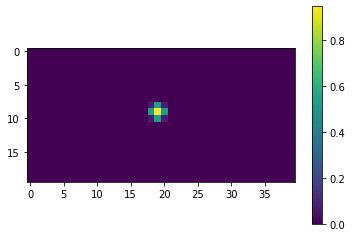

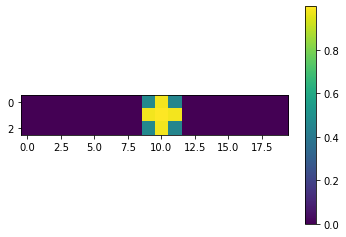

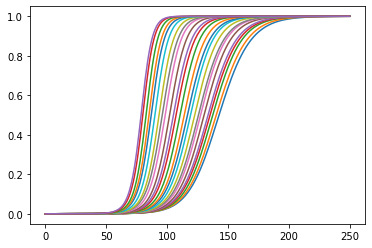

In [14]:
evdis = 2

plt.figure(2)
plt.imshow(nZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(nZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(nZMs);

In [15]:
lex = 0.15
lin = 0.05
sex = 1
sin = 8.15

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
wRTs,wZMs,wZTs,wZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

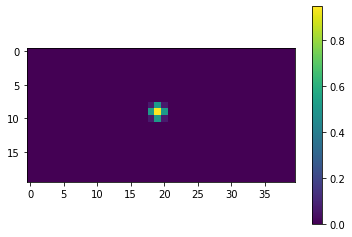

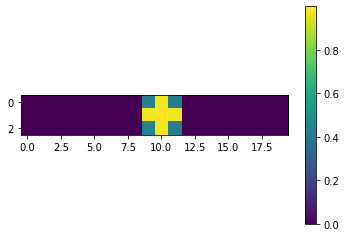

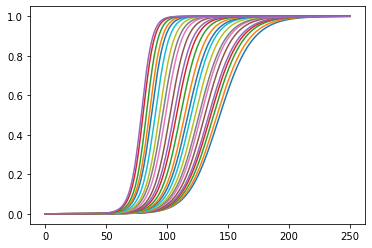

In [16]:
evdis = 2

plt.figure(2)
plt.imshow(wZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(wZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(wZMs);

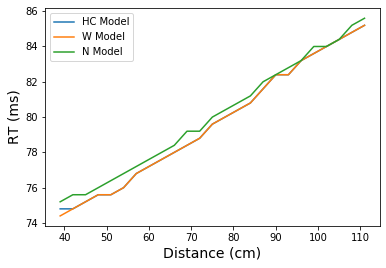

In [17]:
plt.figure(1)
plt.plot(a_distances,RTs,label = 'HC Model')
plt.plot(a_distances,wRTs,label = 'W Model')
plt.plot(a_distances,nRTs,label = 'N Model')
plt.ylabel('RT (ms)',size=14)
plt.xlabel('Distance (cm)',size=14)
plt.legend()

In [18]:
etamin,etamax,dc,h = sigfit(RTs,a_distances)
print('HC model: ',etamin,etamax,dc,1/h)

etamin,etamax,dc,h = sigfit(wRTs,a_distances)
print('W model: ',etamin,etamax,dc,1/h)

etamin,etamax,dc,h = sigfit(nRTs,a_distances)
print('N model: ',etamin,etamax,dc,1/h)

HC model:  72.45149260148939 88.62989833661153 81.13459612681065 0.043890859866219815
W model:  71.6039508073059 89.42397522633756 80.94712692936194 0.039169709484102436
N model:  71.9318649675473 90.6892218171316 83.78026955781354 0.035163070704246464


In [19]:
## Expanding or reducing Sex

lex = 0.15
lin = 0.05
sex = 1.25
sin = 4

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
wsexRTs,wsexZMs,wsexZTs,wsexZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

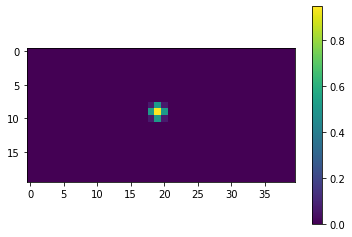

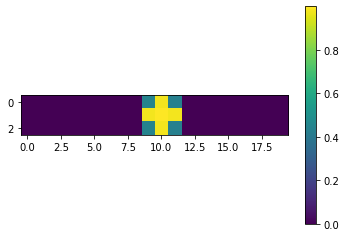

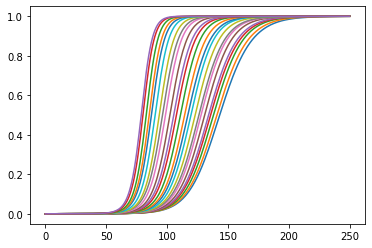

In [20]:
evdis = 2

plt.figure(2)
plt.imshow(wsexZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(wsexZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(wsexZMs);

In [21]:
## Expanding or reducing Sex

lex = 0.15
lin = 0.05
sex = 0.05
sin = 4

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
nsexRTs,nsexZMs,nsexZTs,nsexZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

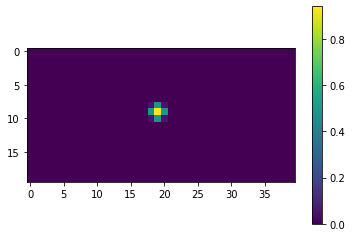

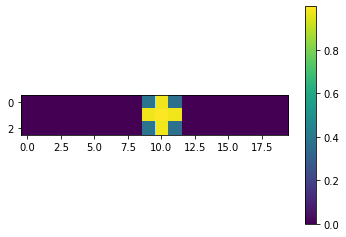

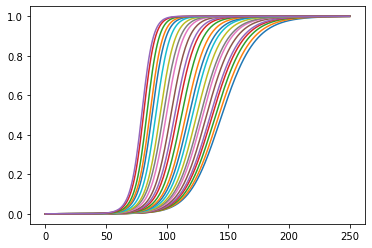

In [22]:
evdis = 2

plt.figure(2)
plt.imshow(nsexZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(nsexZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(nsexZMs);

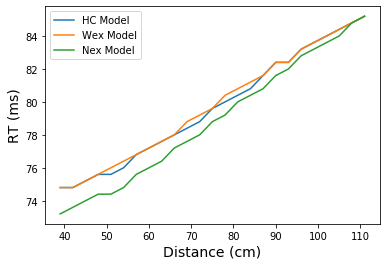

In [23]:
plt.figure(1)
plt.plot(a_distances,RTs,label = 'HC Model')
plt.plot(a_distances,wsexRTs,label = 'Wex Model')
plt.plot(a_distances,nsexRTs,label = 'Nex Model')
plt.ylabel('RT (ms)',size=14)
plt.xlabel('Distance (cm)',size=14)
plt.legend()

In [24]:
## Increasing or decreasing Lex

lex = 1.5
lin = 0.05
sex = 1
sin = 4

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
ilexRTs,ilexZMs,ilexZTs,ilexZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

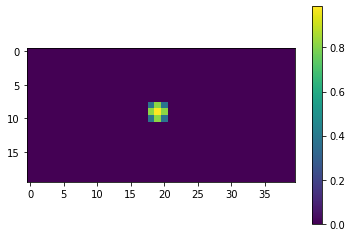

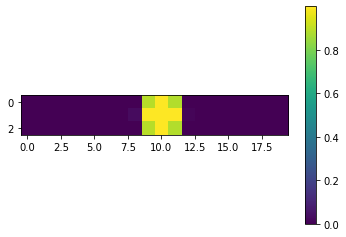

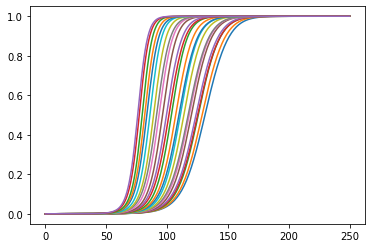

In [25]:
evdis = 2

plt.figure(2)
plt.imshow(ilexZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(ilexZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(ilexZMs);

In [26]:
## Increasing or decreasing Lex

lex = 0.05
lin = 0.05
sex = 1.25
sin = 4

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
dlexRTs,dlexZMs,dlexZTs,dlexZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

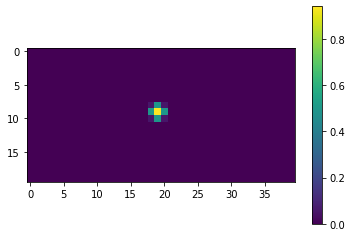

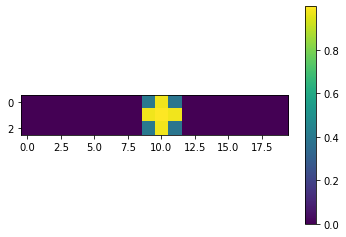

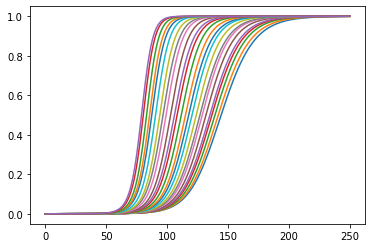

In [27]:
evdis = 2

plt.figure(2)
plt.imshow(dlexZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(dlexZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(dlexZMs);

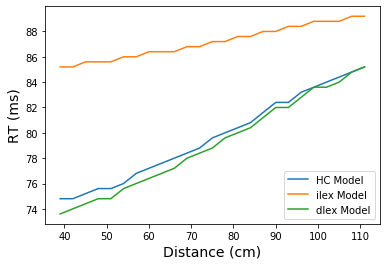

In [28]:
plt.figure(1)
plt.plot(a_distances,RTs,label = 'HC Model')
plt.plot(a_distances,ilexRTs,label = 'ilex Model')
plt.plot(a_distances,dlexRTs,label = 'dlex Model')
plt.ylabel('RT (ms)',size=14)
plt.xlabel('Distance (cm)',size=14)
plt.legend()

In [29]:
## Increasing or decreasing Lin

lex = 0.15
lin = 2.95
sex = 1
sin = 4

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
ilinRTs,ilinZMs,ilinZTs,ilinZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

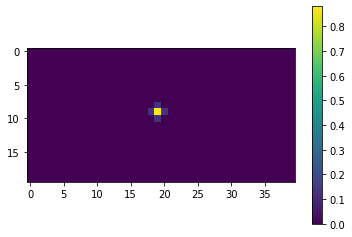

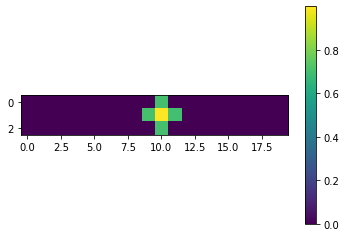

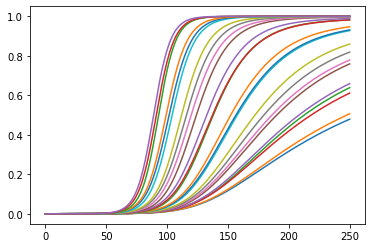

In [30]:
evdis = 2

plt.figure(2)
plt.imshow(ilinZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(ilinZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(ilinZMs);

In [31]:
## Increasing or decreasing Lin

lex = 0.15
lin = 0.01
sex = 1
sin = 4

idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
dlinRTs,dlinZMs,dlinZTs,dlinZAs = myexperimentrun(a_distances,simtime,0,0,lex,lin,sex,sin)

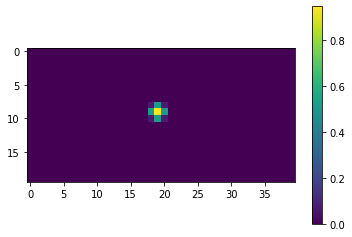

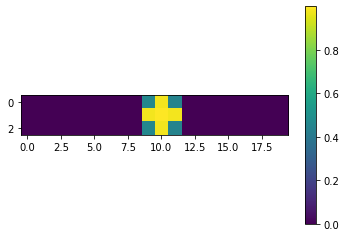

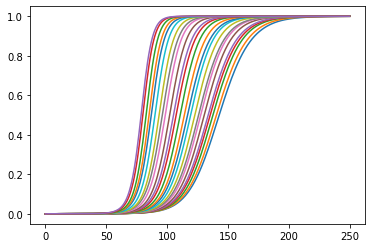

In [32]:
evdis = 2

plt.figure(2)
plt.imshow(dlinZTs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(3)
plt.imshow(dlinZAs[:,:,evdis].transpose());
plt.colorbar()

plt.figure(4)
plt.plot(dlinZMs);

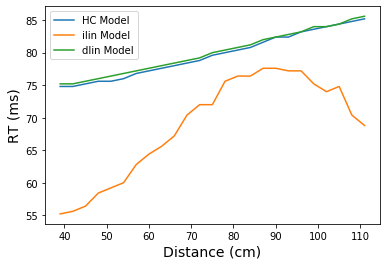

In [33]:
plt.figure(1)
plt.plot(a_distances,RTs,label = 'HC Model')
plt.plot(a_distances,ilinRTs,label = 'ilin Model')
plt.plot(a_distances,dlinRTs,label = 'dlin Model')
plt.ylabel('RT (ms)',size=14)
plt.xlabel('Distance (cm)',size=14)
plt.legend()